In [17]:
# Libraries needed 
import h5py
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from PIL import Image
import scipy
from scipy.spatial.distance import cdist


In [18]:
# upload data 
hdf5data_109 = h5py.File('../../Data/data_109.h5', 'r')
hdf5data_130 = h5py.File('../../Data/data_130.h5', 'r')
hdf5data_142 = h5py.File('../../Data/data_142.h5', 'r')
hdf5data_143 = h5py.File('../../Data/data_143.h5', 'r')

## Transferring detections into a dataframe 


In [19]:
def fill_rows_detections(detections, returndf):
    
    coord_detections = [np.array(vals[0].tolist()) for vals in detections]
    coord_detections = np.vstack(coord_detections)
        
    length_box = [vals[1] for vals in detections]
    width_box = [vals[2] for vals in detections]
    height_box = [vals[3] for vals in detections]
    angle_box = [vals[4] for vals in detections]
    
    returndf["X_box"] = coord_detections[:,0]
    returndf["Y_box"] = coord_detections[:,1]
    returndf["Z_box"] = coord_detections[:,2]
    returndf["length_box"], returndf["width_box"], returndf["height_box"] = length_box, width_box, height_box
    returndf["angle_box"] = angle_box
    
    return returndf

In [20]:
def df_detections(h5data,camera = None):
    
    timestamps = h5data['Timestamp']
    df = pd.DataFrame()
    
    for c, t in enumerate(timestamps):
        
        append_df = pd.DataFrame()
        
        d = h5data['Sequence'][str(c)]
        detection = np.asarray(d['Detections'])
        
        if detection.size:
            append_df = fill_rows_detections(detection, append_df)
            append_df['timestamp'] = t
            append_df['frame'] = c
        
            if camera is not None:
                append_df['camera'] = camera
        
            df = df.append(append_df)
    
    return df

In [21]:
df_109 = df_detections(hdf5data_109, 109)
df_109.reset_index(inplace=True, drop=True)
df_130 = df_detections(hdf5data_130, 130)
df_130.reset_index(inplace=True, drop=True)
df_142 = df_detections(hdf5data_142, 142)
df_142.reset_index(inplace=True, drop=True)
df_143 = df_detections(hdf5data_143, 143)
df_143.reset_index(inplace=True, drop=True)

In [22]:
df_to_concat = [df_109,df_130,df_142,df_143]
df_complete = pd.concat(df_to_concat)
df_complete.sort_values(by = ['frame'], inplace = True)
df_complete.reset_index(inplace=True, drop=True)
df_complete

,X_box,Y_box,Z_box,length_box,width_box,height_box,angle_box,timestamp,frame,camera
0,-11.148409,15.363879,-0.941920,1.177285,0.561967,1.334849,0.631927,1.574333e+09,0,109
1,10.591985,-33.300211,-1.254730,3.106008,2.026976,2.356834,1.390347,1.574333e+09,0,143
2,2.417817,-32.064833,-0.609711,0.641007,0.489730,0.741013,-0.615712,1.574333e+09,0,143
3,13.233552,-5.117304,-0.707404,9.933850,2.673657,1.161759,1.067465,1.574333e+09,0,143
4,27.471277,9.154471,-0.657809,2.640507,0.653304,1.245023,-0.802791,1.574333e+09,0,130
...,...,...,...,...,...,...,...,...,...,...
11740,-5.128264,26.316446,-1.150593,2.670343,1.157835,1.589266,-0.424405,1.574333e+09,749,109
11741,14.617583,-29.436074,-1.085488,5.046473,2.802799,1.898150,-1.309933,1.574333e+09,749,143
11742,-1.142268,-3.922715,-2.524621,12.753714,0.377229,1.433762,-0.278929,1.574333e+09,749,142
11743,9.499622,-1.782256,-1.109378,4.979414,2.787621,1.340728,1.181705,1.574333e+09,749,109


In [ ]:
df_complete[df_complete['frame'] == 700]

## Frame visualization

In [317]:
def convert_to_image_space ( coordinates , world2cam , cam2im ):
    """ Input single set of coordinatetes """
    coord_4 = np.ones (4)
    coord_4[0:3] = coordinates
    cams_coord = ( np.matmul( world2cam , coord_4.T )).T
    cams_coord_4 = np.ones(4)
    
    cams_coord_4 [0:3] = cams_coord [0:3]
    ims_coord = ( np . matmul ( cam2im , cams_coord_4 .T )). T
    # Divide by z coordinate for some reason
    ims_coord [0] = ims_coord [0]/ ims_coord [2]
    ims_coord [1] = ims_coord [1]/ ims_coord [2]
    ims_coord = ims_coord [0:2]
    
    return ( ims_coord )


def visualize_frame_detections ( camera, frame_idx, figsize = None , s = 100):
    """ Input camera file, frame index and size of dot in the picture (default is 100) """
    
    frame = camera['Sequence'][str(frame_idx)]
    detected_points = np.asarray(frame['Detections'])

    x_list = []
    y_list = []

    for point in detected_points:
    
        world_pos = np.array(point[0].tolist())
        fin_pos = convert_to_image_space(world_pos, camera['TMatrixWorldToCam'], camera['ProjectionMatrix'])
        x_list.append(fin_pos[0])
        y_list.append(fin_pos[1])

    # Show image
    a = np.asarray(frame['Image'])
    
    if figsize is not None: 
        plt.figure(figsize = figsize)
        
    plt.imshow(a, cmap = 'gist_gray', zorder = 1)
    plt.scatter(x_list, y_list, s = s, color = 'hotpink', zorder = 3)
    plt.plot([296.40511363,600],[121.374145,250])


    plt.plot([0,800],[180,81.54])



    return

def visualize_frame_boxes ( camera, frame_idx, figsize = None, s = 100):
    """ Input camera file, frame index and size of dot in the picture (default is 100) """
    
    frame = camera['Sequence'][str(frame_idx)]
    detected_points = np.asarray(frame['Detections'])
    
    if figsize is not None: 
        plt.figure(figsize = figsize)
        
    
    for point in detected_points:
        # first face 
        unrotated_vertex1 = np.array([+ point['Length']/2, + point['Width']/2, + point['Height']/2])
        unrotated_vertex2 = np.array([+ point['Length']/2, + point['Width']/2, - point['Height']/2])
        unrotated_vertex3 = np.array([+ point['Length']/2, - point['Width']/2, - point['Height']/2])
        unrotated_vertex4 = np.array([+ point['Length']/2, - point['Width']/2, + point['Height']/2])
        # second face 
        unrotated_vertex5 = np.array([- point['Length']/2, + point['Width']/2, + point['Height']/2])
        unrotated_vertex6 = np.array([- point['Length']/2, + point['Width']/2, - point['Height']/2])
        unrotated_vertex7 = np.array([- point['Length']/2, - point['Width']/2, - point['Height']/2])
        unrotated_vertex8 = np.array([- point['Length']/2, - point['Width']/2, + point['Height']/2])
        
        
        unrotated_vertex_list = [unrotated_vertex1, unrotated_vertex2, unrotated_vertex3, 
                                 unrotated_vertex4, unrotated_vertex5, unrotated_vertex6, 
                                 unrotated_vertex7, unrotated_vertex8]
        
        rotation_matrix = np.array([[np.cos(point['Angle']), -np.sin(point['Angle']), 0], 
                            [np.sin(point['Angle']), np.cos(point['Angle']), 0], 
                            [0,0,1]])
        
        rotated_vertex_list = np.array([rotation_matrix.dot(v) for v in unrotated_vertex_list])
        rotated_vertex_list = rotated_vertex_list + np.array([point['Pos']['X'], point['Pos']['Y'], point['Pos']['Z']])
        
        vertex_im_list = [convert_to_image_space(v, camera['TMatrixWorldToCam'], camera['ProjectionMatrix']) for v in rotated_vertex_list]
        
        
        combinations = [(i,i+1) for i in range(3)] + [(3,0)] + [(i,i+1) for i in range(4,7)] + [
            (7,4)] + [(i,i+4) for i in range(4)]
        
        for (i,j) in combinations: 
            vertex_x_list = [vertex_im_list[i][0],vertex_im_list[j][0]]
            vertex_y_list = [vertex_im_list[i][1],vertex_im_list[j][1]]
            plt.plot(vertex_x_list, vertex_y_list, color = 'b', zorder = 2)
        
        
        
    visualize_frame_detections ( camera, frame_idx, s = s )
    
    return

In [310]:
def credibility_level(df):
    df['credibility_level'] = ""
    for ind,row in df.iterrows():
        coordinates = row[['X_box','Y_box','Z_box']]
        
        if row['camera'] == 109: 
            df.at[ind,'credibility_level'] = level_affidability_109(coordinates);
            
                    
        elif row['camera'] == 130:
            df.at[ind,'credibility_level'] = level_affidability_130(coordinates);
            
            
        elif row['camera'] == 142:
            df.at[ind,'credibility_level'] = level_affidability_142(coordinates);
        
        try:         
            if row['camera'] == 143:
                df.at[ind,'credibility_level'] = level_affidability_143(coordinates);
        except Exception:
                pass

                
def level_affidability_109(coordinates):
    world2cam = hdf5data_109['TMatrixWorldToCam']
    cam2im = hdf5data_109['ProjectionMatrix']
    img_coord = convert_to_image_space ( coordinates , world2cam , cam2im )
    sloap1 = (-250 + 121.374145)/(600-296.40511363)
    sloap2 = 8/65
    if - img_coord[1] <= sloap1*(img_coord[0] - 600) - 250:
        return 1
    elif - img_coord[1] <= sloap2*(img_coord[0]) - 180:
        return 0.75
    else:
        return 0.25

    
def level_affidability_130(coordinates):
    world2cam = hdf5data_130['TMatrixWorldToCam']
    cam2im = hdf5data_130['ProjectionMatrix']
    img_coord = convert_to_image_space ( coordinates , world2cam , cam2im )
    if (img_coord[0] <= 630) & (img_coord[1] >= 100):
        return 1
    elif (img_coord[0] <= 560) & (img_coord[0] >= 420):
        return 0.25
    else: 
        return 0.5
    

    
def level_affidability_142(coordinates):
    world2cam = hdf5data_142['TMatrixWorldToCam']
    cam2im = hdf5data_142['ProjectionMatrix']
    img_coord = convert_to_image_space ( coordinates , world2cam , cam2im )
    if (img_coord[0] <= 600) & (img_coord[0] >= 380) & (img_coord[1] <= 120):
        return 0.25
    elif img_coord[1] > 120:
        return 1
    else: 
        return 0.75

    
def level_affidability_143(coordinates):
    world2cam = hdf5data_143['TMatrixWorldToCam']
    cam2im = hdf5data_143['ProjectionMatrix']
    img_coord = convert_to_image_space ( coordinates , world2cam , cam2im )
    if (img_coord[0] >= 410) & (img_coord[1] <= 120):
        return 0.25
    if (img_coord[0] < 410) & (img_coord[1] <= 120):
        return 0.5
    else: 
        return 1
    

In [311]:
credibility_level(df_complete)

In [312]:
df_complete


,X_box,Y_box,Z_box,length_box,width_box,height_box,angle_box,timestamp,frame,camera,credibility_level
0,-11.148409,15.363879,-0.941920,1.177285,0.561967,1.334849,0.631927,1.574333e+09,0,109,1
1,10.591985,-33.300211,-1.254730,3.106008,2.026976,2.356834,1.390347,1.574333e+09,0,143,1
2,2.417817,-32.064833,-0.609711,0.641007,0.489730,0.741013,-0.615712,1.574333e+09,0,143,1
3,13.233552,-5.117304,-0.707404,9.933850,2.673657,1.161759,1.067465,1.574333e+09,0,143,0.5
4,27.471277,9.154471,-0.657809,2.640507,0.653304,1.245023,-0.802791,1.574333e+09,0,130,1
...,...,...,...,...,...,...,...,...,...,...,...
11740,-5.128264,26.316446,-1.150593,2.670343,1.157835,1.589266,-0.424405,1.574333e+09,749,109,1
11741,14.617583,-29.436074,-1.085488,5.046473,2.802799,1.898150,-1.309933,1.574333e+09,749,143,1
11742,-1.142268,-3.922715,-2.524621,12.753714,0.377229,1.433762,-0.278929,1.574333e+09,749,142,0.25
11743,9.499622,-1.782256,-1.109378,4.979414,2.787621,1.340728,1.181705,1.574333e+09,749,109,0.75


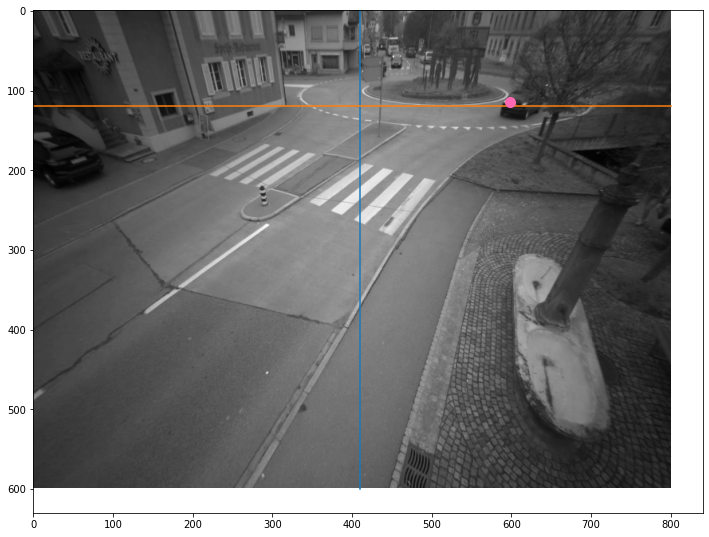

In [272]:
visualize_frame_detections(hdf5data_143,360, figsize = (12,12))

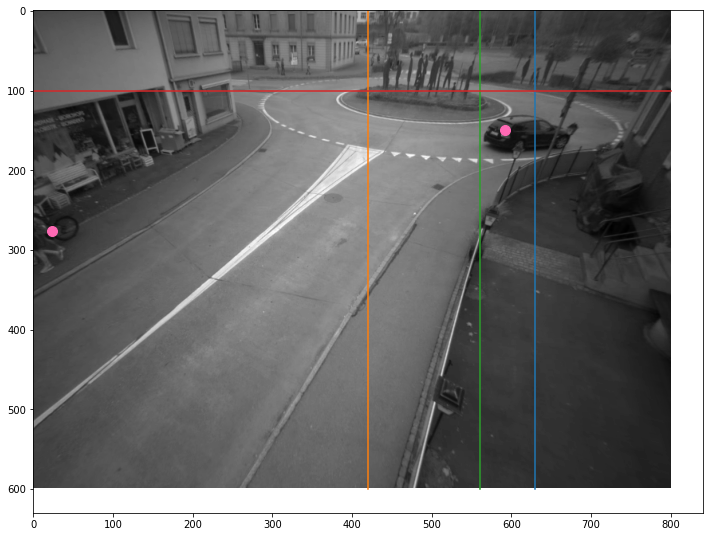

In [314]:
visualize_frame_detections(hdf5data_130,1, figsize = (12,12))

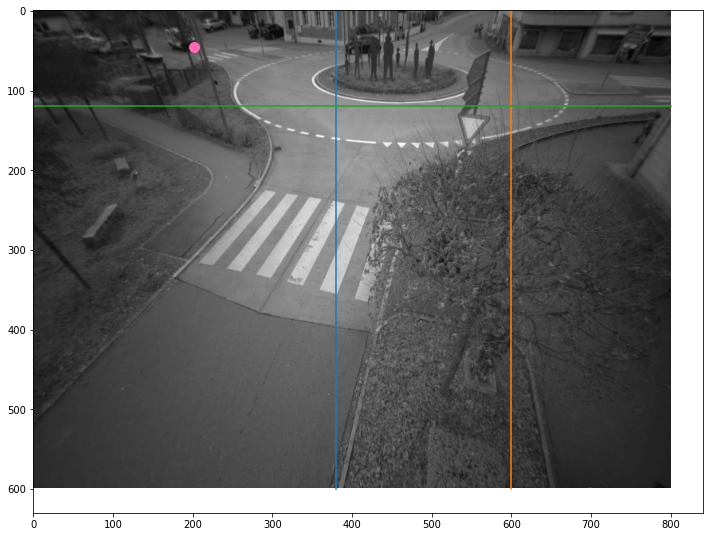

In [316]:
visualize_frame_detections(hdf5data_142,1, figsize = (12,12))

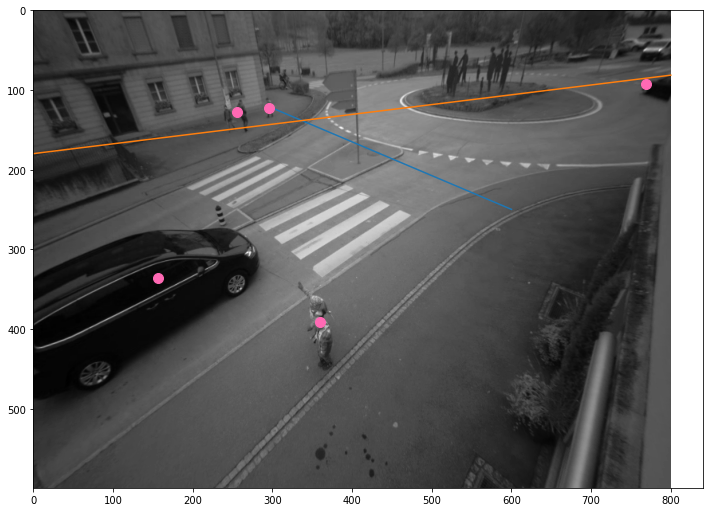

In [318]:
visualize_frame_detections(hdf5data_109,1, figsize = (12,12))

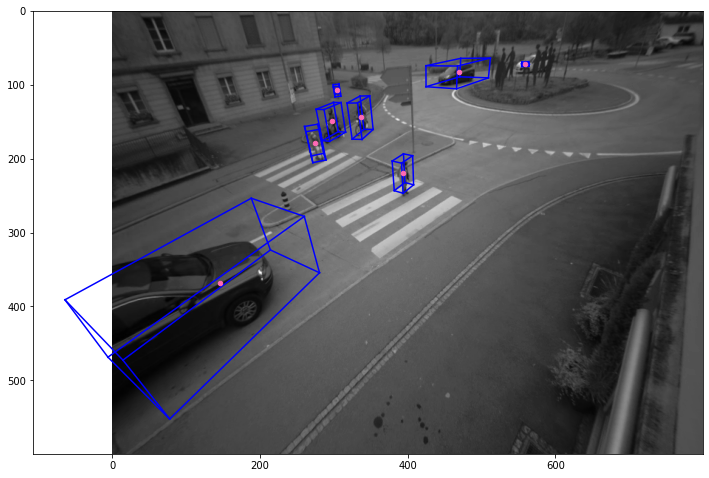

In [34]:
visualize_frame_boxes(hdf5data_109, 260, figsize = (12,12), s = 20)